$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# ECG Heartbeat Classification using Convolutional Architectures <br/> and the PTB dataset, ECG lead II

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf
import pandas as pd
from sklearn.model_selection import train_test_split

import ptb

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

print(device)

# Set the seed for reproducing the results
np.random.seed(42)
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True

cuda


In [3]:
ds_1 = pd.read_csv("data/ptbdb_normal.csv", header=None)
ds_2 = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
ds = pd.concat([ds_1, ds_2])

ds_train, ds_test = train_test_split(ds, test_size=0.2, shuffle=True, stratify=ds[187])
ds_train = torch.tensor(ds_train.values).float()
ds_test = torch.tensor(ds_test.values).float()

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples\n')

print(f'Number of samples labeled 0 (Normal) in train set: {(ds_train[:,187]==0).sum().item()}')
print(f'Number of samples labeled 1 (MI) in train set: {(ds_train[:,187]==1).sum().item()}\n')

y_test = ds_test[:,187].unsqueeze(-1).to(device)
X_test = ds_test[:,list(range(187))].to(device)

in_size = X_test.shape[1]
num_classes = torch.unique(y_test).shape[0]6.
print('input size =', in_size)
print('output size =', num_classes)

Train: 11641 samples
Test: 2911 samples

Number of samples labeled 0 (Normal) in train set: 3237
Number of samples labeled 1 (MI) in train set: 8404

input size = 187
output size = 2


**Now let's plot some random beats:**

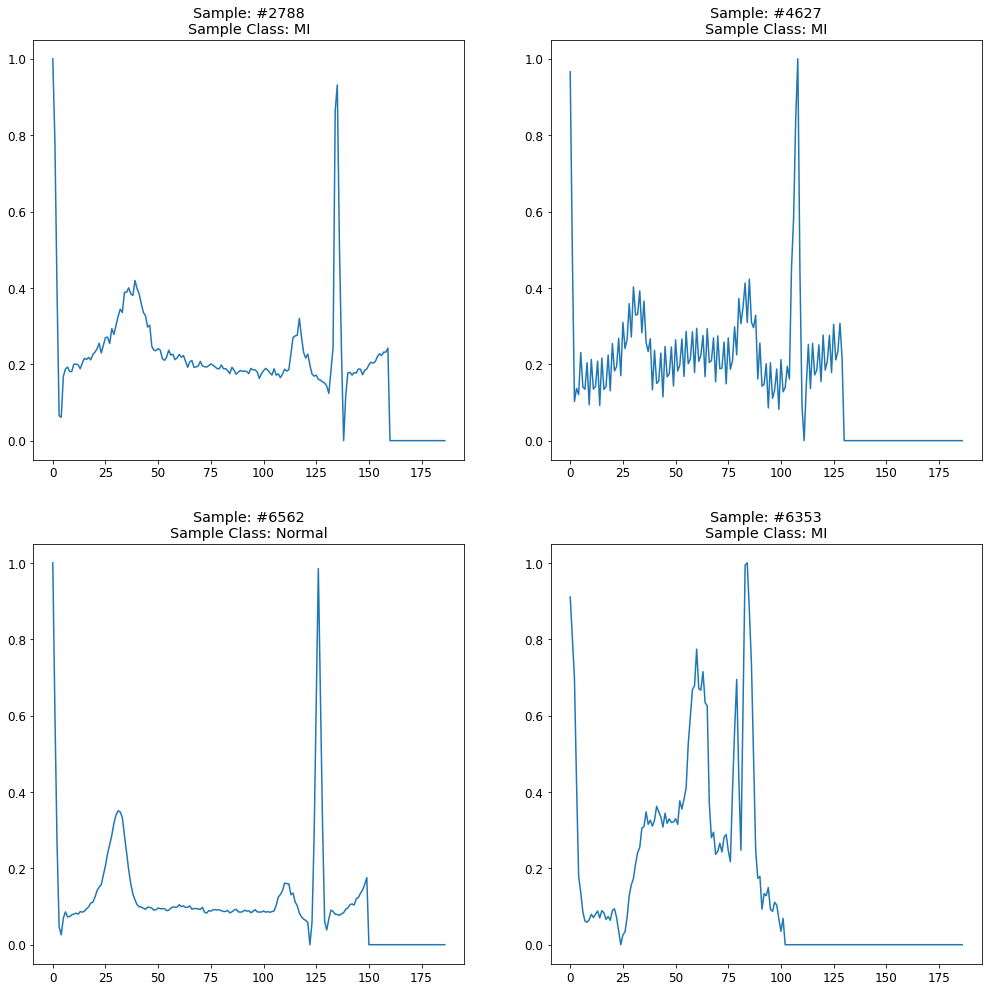

In [4]:
f, axarr = plt.subplots(2, 2, figsize=(17,17))

for x in {0, 1}:
    for y in {0,1}:
        i = np.random.randint(1,11641)
        sample_class = "Normal" if ds_train[i,187].int() == 0 else "MI"
        axarr[x, y].plot(ds_train[i,:187])
        axarr[x, y].set_title("Sample: #" + str(i) + "\nSample Class: " + sample_class)

plt.show()

In [5]:
net = ptb.ConvNet(in_size, num_classes)
print(net)

ConvNet(
  (cnn): Sequential(
    (0): Conv1d(187, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.1, inplace=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.1, inplace=False)
    (6): Conv1d(32, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv1d(256, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): Conv1d(64, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  )
)


Now as usual, as a sanity test let's make sure we can overfit a tiny dataset with our model. But first we need to adapt our `Trainer` for PyTorch models.

In [6]:
import training

batch_size = 2
max_batches = 10
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)

# Create model, loss and optimizer instances
model = ptb.ConvNet(in_size, num_classes)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Use TorchTrainer to run only the training loop a few times.
trainer = training.TorchTrainer(model, loss_fn, optimizer, device)
best_acc = 0
for i in range(30):
    res = trainer.train_epoch(dl_train, max_batches=max_batches, verbose=(i%2==0))
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc
    if best_acc == 100:
        break
    
# Test overfitting
test.assertGreaterEqual(best_acc, 95)

train_batch (Avg. Loss 0.139, Accuracy 95.0): 100%|██████████| 10/10 [00:00<00:00, 62.51it/s]


## Training the model

In [7]:
from experiments import save_experiment
import time

train = True # use false to skip training

if train:
    print("--- Training Model ---")
    model = ptb.ConvNet(in_size, num_classes)
    model = model.to(device)
    loss = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)

    trainer = training.TorchTrainer(model, loss, optimizer, scheduler, device)

    bs_train = 100
    bs_test = 20
    early_stopping = 5
    checkpoints = None
    epochs = 3000
    batches = 1000

    dl_train = torch.utils.data.DataLoader(ds_train, bs_train, shuffle=False)
    dl_test = torch.utils.data.DataLoader(ds_test, bs_test, shuffle=False)
    start_time = time.time()
    fit_res = trainer.fit(dl_train=dl_train, dl_test=dl_test,
                            early_stopping=early_stopping,
                            checkpoints=checkpoints, num_epochs=epochs, max_batches=batches)

    end_time = time.time()

    print("--- Running Time: %s seconds ---" % (end_time - start_time))
    print("--- Saving Model ---")
    torch.save(model.state_dict(), "./models/PTB_CNN.pt")
    save_experiment("PTB_CNN", "./results", fit_res)

else:
    print("--- Skipping Training & Loading Model ---")
    model = ptb.ConvNet(in_size, num_classes)
    model.load_state_dict(torch.load("./models/PTB_CNN.pt"))
    model.eval()
    model = model.to(device)

--- Training Model ---
--- EPOCH 1/3000 ---
test_batch (Avg. Loss 0.437, Accuracy 78.7): 100%|██████████| 146/146 [00:00<00:00, 384.56it/s]
--- EPOCH 2/3000 ---
test_batch (Avg. Loss 0.374, Accuracy 83.4): 100%|██████████| 146/146 [00:00<00:00, 374.65it/s]
--- EPOCH 3/3000 ---
test_batch (Avg. Loss 0.345, Accuracy 85.1): 100%|██████████| 146/146 [00:00<00:00, 347.75it/s]
--- EPOCH 4/3000 ---
test_batch (Avg. Loss 0.311, Accuracy 87.9): 100%|██████████| 146/146 [00:00<00:00, 355.79it/s]
--- EPOCH 5/3000 ---
test_batch (Avg. Loss 0.293, Accuracy 88.3): 100%|██████████| 146/146 [00:00<00:00, 373.99it/s]
--- EPOCH 6/3000 ---
test_batch (Avg. Loss 0.278, Accuracy 89.1): 100%|██████████| 146/146 [00:00<00:00, 369.87it/s]
--- EPOCH 7/3000 ---
test_batch (Avg. Loss 0.271, Accuracy 89.3): 100%|██████████| 146/146 [00:00<00:00, 364.21it/s]
--- EPOCH 8/3000 ---
test_batch (Avg. Loss 0.256, Accuracy 90.3): 100%|██████████| 146/146 [00:00<00:00, 355.24it/s]
--- EPOCH 9/3000 ---
test_batch (Avg. Los

### Plotting the results

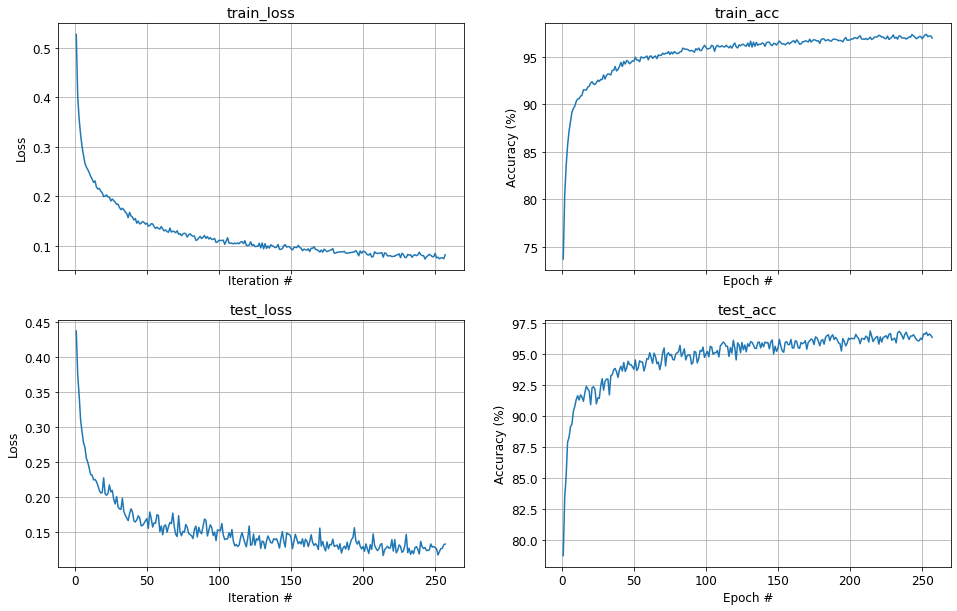

In [8]:
from experiments import load_experiment
from cs236781.plot import plot_fit

fit_res = load_experiment('results/PTB_CNN.json')
_, _ = plot_fit(fit_res)

### Confusion Matrix

Normalized confusion matrix


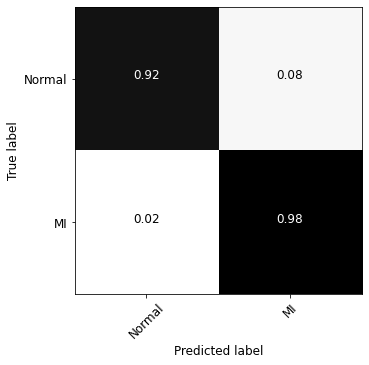

In [9]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix

with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()
    
cnf_matrix = confusion_matrix(y_test.cpu().numpy(), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'MI'], normalize=True)

plt.savefig("figures/PTB CNN confusion matrix.pdf", format="pdf", bbox_inches = "tight")
plt.show() 